# Running and fitting EZmock

-----
This jupyter notebook demonstrates the process of generating EZmock catalogues with user-supplied parameters and comparing the clustering measurements with references.

In [1]:
import os, sys
pyez_path = os.getcwd() + '/python'
if not os.path.isfile(pyez_path + '/pyEZmock.py'):
    pyez_path='/global/u2/z/zhaoc/work/pyEZmock/python'
sys.path.append(pyez_path)
from pyEZmock import pyEZmock
%matplotlib inline

-----
The `pyEZmock` class should be initialised with the working directory, and optionally the locations of the EZmock and clustering codes, e.g.

```python
ez = pyEZmock(workdir, exe='/path/to/EZmock', pk_exe='/path/to/powspec',
              xi_exe='/path/to/FCFC', bk_exe='/path/to/bispec')
```

The `set_param` and `set_clustering` functions initialise parameters for EZmock construction and clustering measurements.
For parameters that do not vary during the fit, it is recommended to set them at initialisation (via the `set_param` function).
The clustering statistics to be computed, as well as the references for the fit, are defined by the `set_clustering` function. In particular, both real- and redshift-space clustering measurements are supported.

Please consult `help(ez.set_param)` and `help(ez.set_clustering)` for detailed explanations of the parameters.

In [2]:
workdir = os.environ['SCRATCH'] + '/EZmock'
ez = pyEZmock(workdir)
ez.set_param(boxsize=1000, num_grid=256, redshift=0.9873, num_tracer=1000000, omega_m=0.3089,
            init_pk='data/Planck15.UNIT.loguniform.pk')
ez.set_clustering(pk='both', pk_grid=512, xi='redshift', xi_z_ref_col=[1,2], bk='redshift', bk_grid=512,
    pk_r_ref='test/PK_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_4col_real.dat',
    pk_z_ref='test/PK_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_4col.dat',
    xi_z_ref='test/2PCF_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_4col.dat',
    bk_z_ref='test/BK_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_4col.dat')

-----
Free parameters for the fit can be set via the `run` function, which generates the job script for running EZmocks and clustering measurements. The job script can be either submitted to a slurm queue, or run manually when `queue` is not provided. And the typical 4 free parameters for EZmocks are listed below:

| Parameter     | Description                              |
|---------------|------------------------------------------|
| `pdf_base`    | Base number for PDF mapping              |
| `dens_scat`   | Density scattering scaling parameter     |
| `rand_motion` | Scatter of peculiar velocity             |
| `dens_cut`    | Critical density for structure formation |

For physical explanations of the parameters, see [arXiv:2007.08997](https://arxiv.org/abs/2007.08997). And the impacts of the parameters on clustering statistics can be found in the [\[cheatsheet\]](doc/EZmock_params_cheatsheet.pdf).

In practice, the function `run` is expected to be called many times for the fit. However, it may take long before the job enters the queue. It is thus highly recommended to reserve an interactive node, and run the job manually there, by e.g.

```
salloc -N 1 -q interactive -L SCRATCH -C haswell -t 4:00:00
```

In [3]:
# Submit the job to the debug queue (not recommended for fit).
ez.run(nthreads=64, queue='debug', pdf_base=0.5, dens_scat=1, rand_motion=100, dens_cut=1.02)

# Provide a command for running the job manually (recommended with interactive nodes).
#ez.run(nthreads=64, pdf_base=0.5, dens_scat=1, rand_motion=100, dens_cut=0)

Submitted batch job 38139248


'/global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.5d1r100c1.02_seed1/run_job.sh'

-----
Plot clustering measurements set via the `set_clustering` function, obtained from the following sources in sequence:

1.   previous runs;
2.   the references;
3.   the current run.

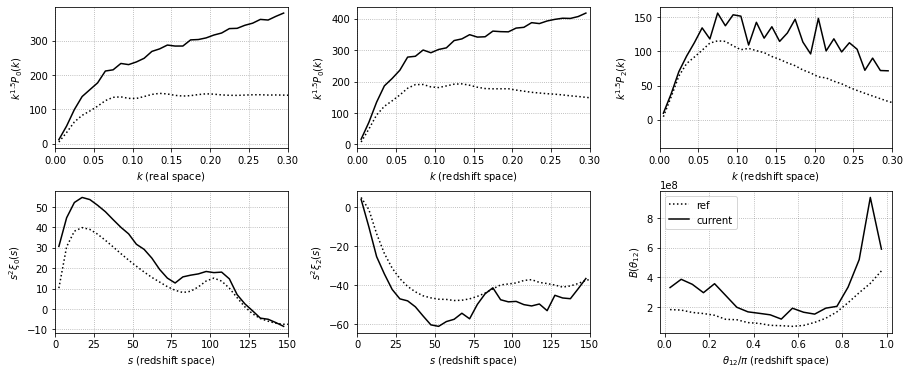

In [4]:
ez.plot()

-----
Continue running EZmocks and making plots after parameter revision.

In [5]:
ez.run(nthreads=64, pdf_base=0.2, dens_scat=1, rand_motion=100, dens_cut=1.02)

Job script generated. Please run the following command manually:
bash /global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.2d1r100c1.02_seed1/run_job.sh


'/global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.2d1r100c1.02_seed1/run_job.sh'

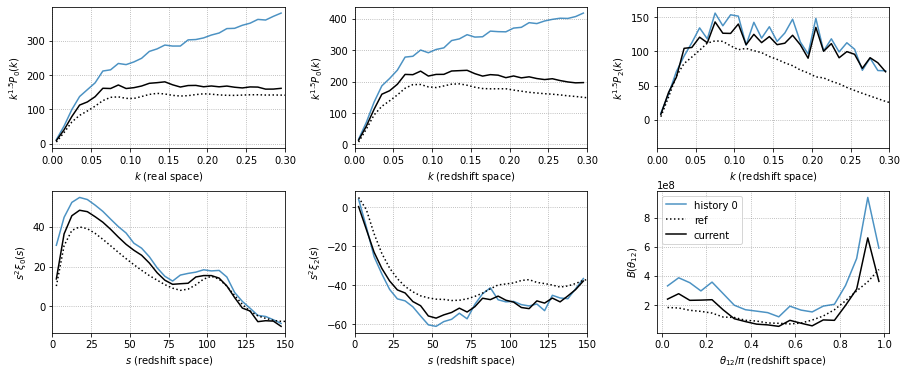

In [6]:
ez.plot()

In [7]:
ez.run(nthreads=64, pdf_base=0.2, dens_scat=0.5, rand_motion=100, dens_cut=1.02)

Job script generated. Please run the following command manually:
bash /global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.2d0.5r100c1.02_seed1/run_job.sh


'/global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.2d0.5r100c1.02_seed1/run_job.sh'

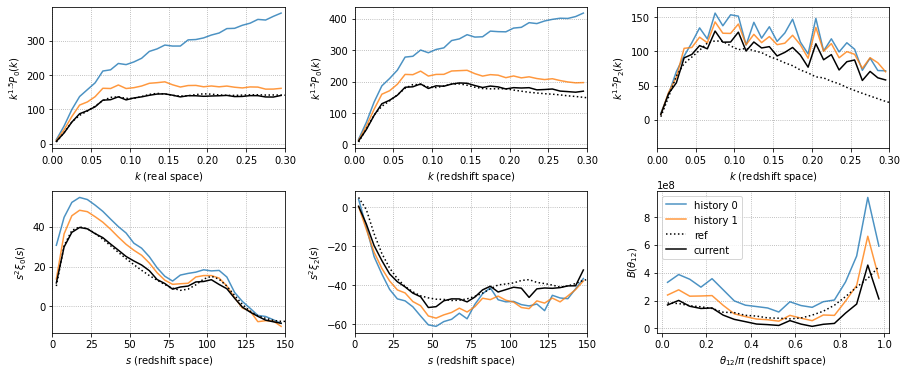

In [8]:
ez.plot()

In [9]:
ez.run(nthreads=64, pdf_base=0.2, dens_scat=0.5, rand_motion=200, dens_cut=1.02)

Job script generated. Please run the following command manually:
bash /global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.2d0.5r200c1.02_seed1/run_job.sh


'/global/cscratch1/sd/zhaoc/EZmock/B1000G256Z0.9873N1000000_b0.2d0.5r200c1.02_seed1/run_job.sh'

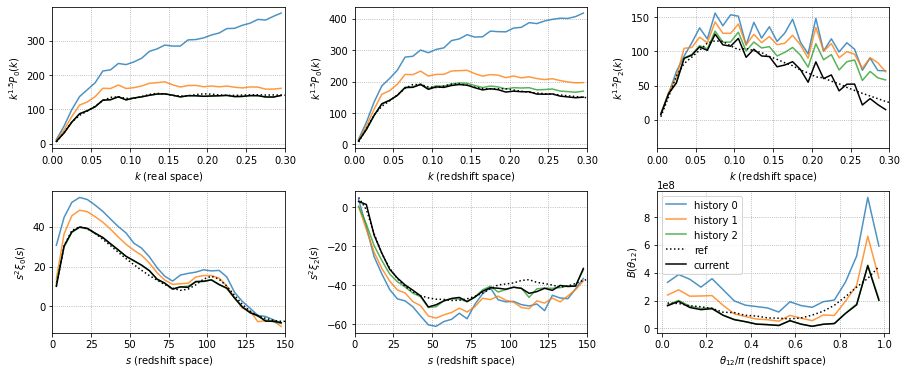

In [10]:
ez.plot()

-----
Generate the job for the mass production of mocks, with different random seeds. Note that it is possible to change the configurations for clustering measurements using `ez.set_clustering` before the mass production.

If the `queue` argument is missing, a job list file for the [jobfork](https://github.com/cheng-zhao/jobfork) tool is generated. The MPI scheduler of this tool runs the list of jobs in parallel.

If `queue` is provided, the job can be submitted by `sbatch <job_script>`, where `job_script` is the return value of `massive_jobs`. This job script runs multiple jobs in parallel, see the [NERSC docs](https://docs.nersc.gov/jobs/examples/#multiple-parallel-jobs-simultaneously).

In [11]:
# Generate a job script for all realisations.
ez.massive_jobs(nthreads=32, seeds=range(4), queue='regular', clustering=False)

# Provide a job list file for the jobfork tool.
#ez.massive_jobs(nthreads=32, seeds=range(4), clustering=False)

The job script for 2 realisations have been generated.
Please check it before submission:
/global/cscratch1/sd/zhaoc/EZmock/submit_mass_production.sh


'/global/cscratch1/sd/zhaoc/EZmock/submit_mass_production.sh'

-----
Check parameters of the current (`params` function) and previous (`history` function) runs. The indices of the histories are consistent with the ones showing in the plots above. 

In [12]:
ez.params()
print('----------')
ez.history()

boxsize = 1000.0
num_grid = 256
redshift = 0.9873
num_tracer = 1000000
pdf_base = 0.2
dens_scat = 0.5
rand_motion = 200.0
dens_cut = 1.02
seed = 1
omega_m = 0.3089
z_init = 0.0
init_pk = /global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk
----------
0: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.5, 'dens_scat': 1.0, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, 'omega_m': 0.3089, 'z_init': 0.0, 'init_pk': '/global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk'}
1: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.2, 'dens_scat': 1.0, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, 'omega_m': 0.3089, 'z_init': 0.0, 'init_pk': '/global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk'}
2: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.2, 'dens_scat': 0.5, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, '

-----
Clear the histories by slices.

In [13]:
ez.clear(slice(0,2))    # same as removing history[0:2]
#ez.clear(slice(None))   # remove all histories
ez.history()

0: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.2, 'dens_scat': 0.5, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, 'omega_m': 0.3089, 'z_init': 0.0, 'init_pk': '/global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk'}


-----
To recover histories, one could reinitialise the `pyEZmock` class with the `restore` argument.

In [14]:
ez = pyEZmock(workdir, restore=True)
ez.history()

0: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.2, 'dens_scat': 1.0, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, 'omega_m': 0.3089, 'z_init': 0.0, 'init_pk': '/global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk'}
1: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.2, 'dens_scat': 0.5, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, 'omega_m': 0.3089, 'z_init': 0.0, 'init_pk': '/global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk'}
2: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.5, 'dens_scat': 1.0, 'rand_motion': 100.0, 'dens_cut': 1.02, 'seed': 1, 'omega_m': 0.3089, 'z_init': 0.0, 'init_pk': '/global/u2/z/zhaoc/work/pyEZmock/data/Planck15.UNIT.loguniform.pk'}
3: {'boxsize': 1000.0, 'num_grid': 256, 'redshift': 0.9873, 'num_tracer': 1000000, 'pdf_base': 0.2, 'dens_scat': 0.5, 'rand_motion': 200.0, 'dens_cut':